# <font color = 'indianred'>**Multilabel Classification of Twitter tweets Dataset based on emotions using ModernBert** </font>

**Objective:**

In this notebook, we aim to build the base model without accounting for the data imbalance. We will learn how the label imbalance can influence our results.


**Plan**

1. Set Environment
2. Load Dataset
3. Accessing and Manipulating Splits
4. Load Pre-trained Tokenizer
5. Create Function for Tokenizer
4. Train Model
  1. Download pre-trained model <br>
  2. Download and modify the model config file <br>
  3. Compute Metric Function <br>
  4. Training Arguments <br>
  5. Instantiate Trainer <br>
  6. Setup WandB <br>
  7. Training and Validation
6. Performance on Test Set
7. Model Inference






















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [1]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  !pip install uv -qq
  !uv pip install numpy -U -qq

  !uv pip install transformers evaluate wandb datasets accelerate -U -qq ## NEW LINES ##


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 127.4 MB/s eta 0:00:00


 <Font size = 5 color = 'indianred'>**Restart the session before moving onto next cell**
> Runtime- Restart Session

<font color = 'indianred'> *Load Libraries* </font>

In [1]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gc
import time
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib

In [3]:
# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import TrainingArguments, Trainer, set_seed
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import pipeline
import wandb
from google.colab import userdata
from huggingface_hub import login
import torch
import torch.nn as nn
import ast

In [4]:
set_seed(42)

In [5]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_Token')


In [6]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")


Successfully logged in to Hugging Face!


In [7]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ronchaudhuri29 (ronchaudhuri29-the-university-of-texas-at-dallas) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Successfully logged in to WANDB!


In [8]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")

# <font color = 'indianred'> **2. Load Data set**
    


In [10]:
from pathlib import Path

if 'google.colab' in str(get_ipython()):

    llm_folder = Path('/content/')

else:

    llm_folder = Path(r"C:\Users\hp\OneDrive - The University of Texas at Dallas\LLM")

data_folder = llm_folder / 'data'
notebooks_folder = llm_folder / 'notebooks'

print("LLM folder path:", llm_folder)

LLM folder path: /content


In [11]:
data_folder = llm_folder / 'data'
model_folder = llm_folder / '0_saved_models/HW3'
model_folder.mkdir(exist_ok=True, parents=True)
data_folder.mkdir(exist_ok=True, parents=True)

In [14]:
df = pd.read_csv(data_folder/'emotion_detection (1).csv')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7724 entries, 0 to 7723
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            7724 non-null   object
 1   Tweet         7724 non-null   object
 2   anger         7724 non-null   int64 
 3   anticipation  7724 non-null   int64 
 4   disgust       7724 non-null   int64 
 5   fear          7724 non-null   int64 
 6   joy           7724 non-null   int64 
 7   love          7724 non-null   int64 
 8   optimism      7724 non-null   int64 
 9   pessimism     7724 non-null   int64 
 10  sadness       7724 non-null   int64 
 11  surprise      7724 non-null   int64 
 12  trust         7724 non-null   int64 
dtypes: int64(11), object(2)
memory usage: 784.6+ KB


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7719,2018-01993,@BadHombreNPS @SecretaryPerry If this didn't m...,1,0,1,0,0,0,0,0,0,0,0
7720,2018-01784,Excited to watch #stateoforigin tonight! Come ...,0,0,0,0,1,0,1,0,0,0,0
7721,2018-04047,"Blah blah blah Kyrie, IT, etc. @CJC9BOSS leavi...",1,0,1,0,0,0,0,0,1,0,0
7722,2018-03041,#ThingsIveLearned The wise #shepherd never tru...,0,0,0,0,0,0,0,0,0,0,0


In [15]:
import pandas as pd
from datasets import Dataset

#Define emotion label columns
class_names = [
    'anger', 'anticipation', 'disgust', 'fear', 'joy',
    'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'
]

#Create a "label" column with list of emotions per tweet
df['label'] = df[class_names].values.tolist()

# Keep only text + labels
df_final = df[['Tweet', 'label']].rename(columns={'Tweet': 'text'})

# Convert to Hugging Face dataset
dataset = Dataset.from_pandas(df_final)

print(dataset[0])

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry", 'label': [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]}


# <font color = 'indianred'> **3. Accessing and Manuplating Splits**</font>

<font color = 'indianred'>*Create futher subdivions of the splits*</font>

In [32]:
# Split the test set into test and validation sets
test_val_splits = dataset.train_test_split(test_size=0.4, seed=42)
train_split= test_val_splits['train']
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42,)
val_split = test_val_splits['train']
test_split = test_val_splits['test']

<font color = 'indianred'>*small subset for initial experimenttaion*</font>

In [33]:
train_val_subset= DatasetDict(
    {"train": train_split, "valid": val_split})

train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4634
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1545
    })
})

In [34]:
train_val_subset['train']['label'][0]

[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]

# <font color = 'indianred'>**4. Load pre-trained Tokenizer**</font>



In [35]:
checkpoint = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

#<font color = 'indianred'> **5. Create function for Tokenizer**



In [36]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

<font color = 'indianred'> *Use map function to apply tokenization to all splits*

> Add blockquote



In [37]:
tokenized_dataset= train_val_subset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/4634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [38]:
tokenized_dataset['train']['label'][0:3]

tensor([[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

#  <font color = 'indianred'> **6. Model Training**

##  <font color = 'indianred'> **6.1 Download pre-trained model**

In [52]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 11, problem_type="multi_label_classification")  # We are using the same checkpiont as we have used for tokenizer

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##  <font color = 'indianred'> **6.2 Downaload and Modify Model Config File**

In [53]:
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
config.id2label = id2label
config.label2id = label2id
model.config = config


##  <font color = 'indianred'> **6.3 compute_metrics function** </font>



In [54]:
# load training metrices
f1 = evaluate.load('f1','multilabel')


def compute_metrics(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    # Apply sigmoid to convert logits to probabilities for multilabel
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    # Apply a threshold (e.g., 0.5) to get binary predictions for each label
    predictions = (probs > 0.5).astype(int)

    # Compute multilabel metrics
    f1_macro = f1.compute(predictions=predictions, references=labels, average='macro')['f1']

    return {'f1_macro': f1_macro}

## <font color = 'indianred'> **6.4 Training Arguments**</font>


In [55]:
# Define the directory where model checkpoints will be saved
model_folder = Path("/content/bert_multilabel")
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'Tweet_check'

# Configure training parameters
training_args = TrainingArguments(
    seed = 42,
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    # per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    # per_device_eval_batch_size=16,

    per_device_train_batch_size=4,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},

    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases
)


##  <font color = 'indianred'> **6.5 Initialize Trainer**</font>



In [57]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

In [58]:
pos_weights = calculate_pos_weights(tokenized_dataset)

In [59]:
pos_weights

tensor([ 1.6270,  5.9789,  1.6166,  4.6306,  1.7404,  8.7149,  2.4301,  7.6294,
         2.3006, 19.0606, 19.1478])

In [60]:
# initialize trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [61]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/tmp/ipython-input-3012450716.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


## <font color = 'indianred'> **6.6 Setup WandB**</font>

In [62]:
%env WANDB_PROJECT = multilabel_stack

env: WANDB_PROJECT=multilabel_stack


##  <font color = 'indianred'> **6.7 Training and Validation**

In [63]:
free_gpu_memory()

GPU memory has been freed.


In [64]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


Step,Training Loss,Validation Loss,F1 Macro
20,4.413900,1.084543,0.272668
40,4.202000,1.054264,0.322290
60,4.060600,1.026282,0.383514
80,3.861300,0.996218,0.405796
100,3.789200,0.971304,0.404792
120,4.050100,0.949419,0.422618
140,3.694200,0.911520,0.454923
160,3.785800,0.900543,0.457552
180,3.786400,0.876380,0.473025
200,3.425400,0.862230,0.484855


<font color = 'indianred'> *Evaluate model on Validation Set* </font>


In [65]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [66]:
eval_results

{'eval_loss': 0.7916319966316223,
 'eval_f1_macro': 0.5399514836715887,
 'eval_runtime': 11.4458,
 'eval_samples_per_second': 134.984,
 'eval_steps_per_second': 33.811,
 'epoch': 2.0}

In [67]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"], "eval_loss": eval_results["eval_loss"],})

<font color = 'indianred'> *Finetune threshold* </font>

In [68]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(tokenized_dataset["valid"])

# Get probabilities from logits
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits)
valid_labels = np.array(valid_output.label_ids.astype(int))

In [69]:
valid_logits.shape

(1545, 11)

In [70]:
valid_probs.shape

(1545, 11)

In [71]:
valid_labels.shape

(1545, 11)

In [72]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics



In [73]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)


In [74]:
optimal_thresholds

[np.float32(0.6000819),
 np.float32(0.52726424),
 np.float32(0.3453733),
 np.float32(0.7158258),
 np.float32(0.66173804),
 np.float32(0.7541251),
 np.float32(0.68700516),
 np.float32(0.72044647),
 np.float32(0.58775115),
 np.float32(0.70880556),
 np.float32(0.8204335)]

In [75]:
f1 = evaluate.load('f1','multilabel')
def compute_metrics_val(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_macro':f1_macro['f1'],}

In [76]:
compute_metrics_val((valid_logits, valid_labels), optimal_thresholds)

{'f1_macro': 0.5679547204323206}

<font color = 'indianred'> *Confusion Matrix*</font>

In [77]:
valid_preds = (valid_probs > optimal_thresholds).astype(int)
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
print(mcm)

[[[ 839  172]
  [ 116  418]]

 [[1105  220]
  [ 113  107]]

 [[ 637  335]
  [  59  514]]

 [[1196   74]
  [ 115  160]]

 [[ 861   87]
  [ 135  462]]

 [[1212  153]
  [  60  120]]

 [[ 955  136]
  [ 134  320]]

 [[1241  115]
  [ 109   80]]

 [[ 878  225]
  [ 111  331]]

 [[1430   45]
  [  44   26]]

 [[1374  101]
  [  43   27]]]


In [78]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


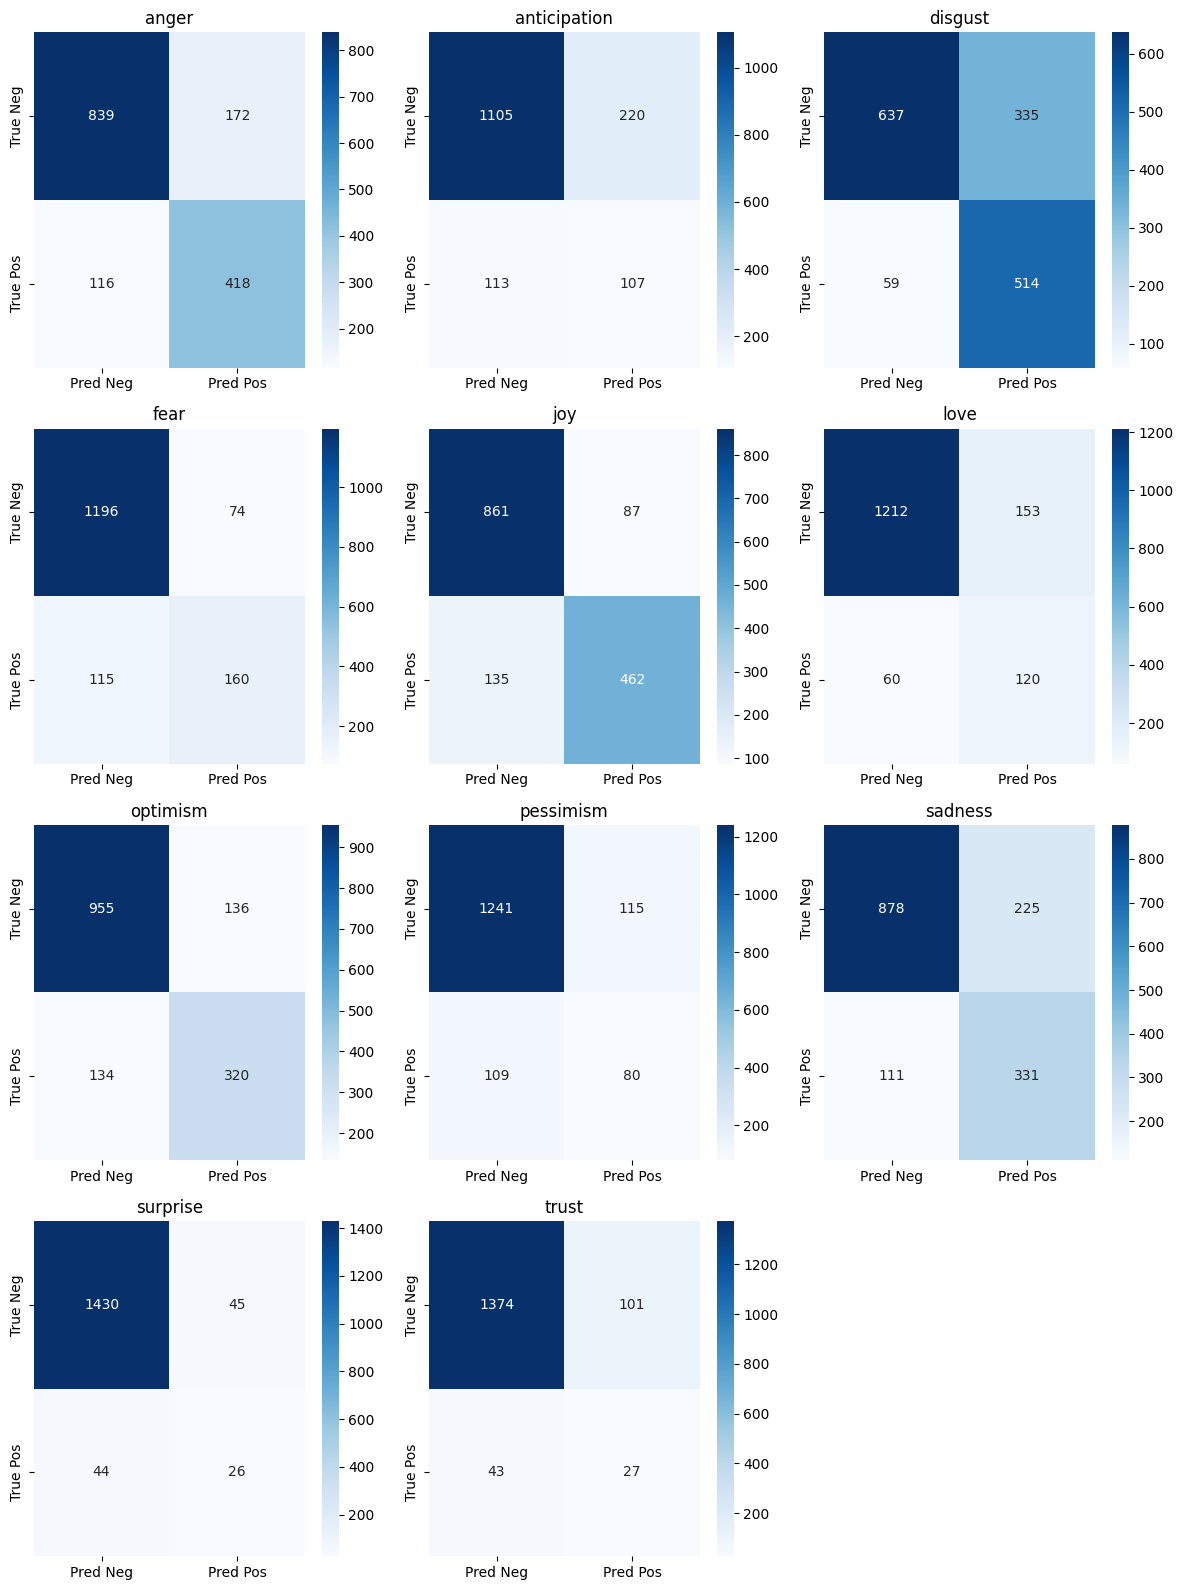

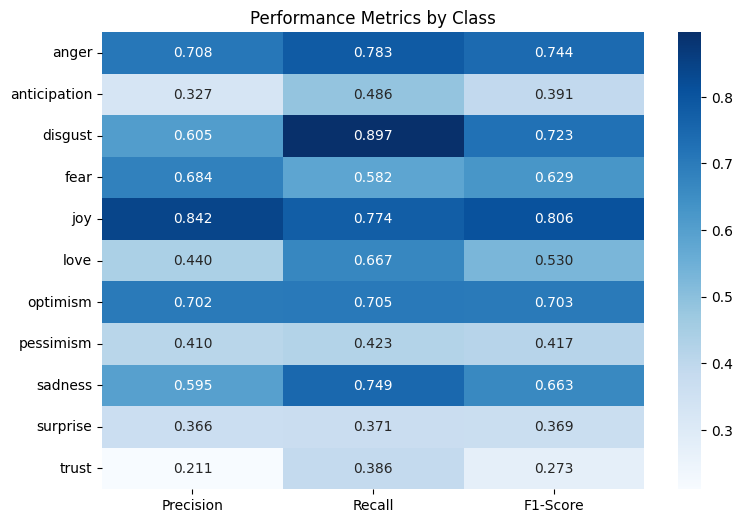

<Figure size 1200x533.333 with 0 Axes>

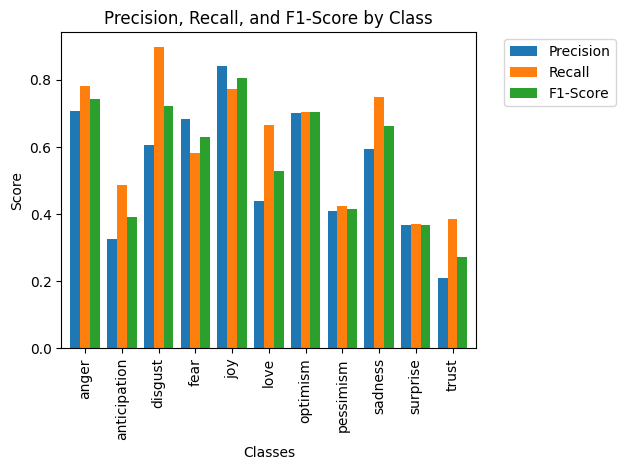

{'macro_avg': {'precision': np.float64(0.5354936580848666),
  'recall': np.float64(0.6202418545143399),
  'f1': np.float64(0.5679547204323206)},
 'per_class': {'Precision': {'anger': 0.7084745762711865,
   'anticipation': 0.327217125382263,
   'disgust': 0.6054181389870436,
   'fear': 0.6837606837606838,
   'joy': 0.8415300546448088,
   'love': 0.43956043956043955,
   'optimism': 0.7017543859649122,
   'pessimism': 0.41025641025641024,
   'sadness': 0.5953237410071942,
   'surprise': 0.36619718309859156,
   'trust': 0.2109375},
  'Recall': {'anger': 0.7827715355805244,
   'anticipation': 0.4863636363636364,
   'disgust': 0.8970331588132635,
   'fear': 0.5818181818181818,
   'joy': 0.7738693467336684,
   'love': 0.6666666666666666,
   'optimism': 0.7048458149779736,
   'pessimism': 0.42328042328042326,
   'sadness': 0.748868778280543,
   'surprise': 0.37142857142857144,
   'trust': 0.38571428571428573},
  'F1-Score': {'anger': 0.7437722419928826,
   'anticipation': 0.3912248628884826,
 

In [79]:
multilabel_evaluation(y_true=valid_labels, y_pred=valid_preds, class_names=class_names, figsize=(12, 8))

<font color = 'indianred'> *Get best checkpoint*</font>


In [80]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 460.


#  <font color = 'indianred'> **7. Performance on Test Set** </font>
For test set evaluation, we will perform following steps:



In [81]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/bert_multilabel/checkpoint-460'

In [82]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [83]:
test_set_tokenized = test_split.map(tokenize_fn, batched=True)


Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [84]:
test_set_tokenized

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1545
})

In [85]:
test_set_tokenized.set_format(type='torch')
test_set_tokenized = (test_set_tokenized
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

<font color = 'indianred'>*Training Arguments*</font>

In [86]:
training_args = TrainingArguments(
    seed = 42,
    output_dir="./results",
    per_device_eval_batch_size=8,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

<font color = 'indianred'>*Instantiate Trainer*</font>

In [87]:
from functools import partial

In [88]:
compute_metrics_fn = partial(compute_metrics_val, thresholds=optimal_thresholds)

In [89]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics_fn,
    processing_class=tokenizer,
)

<font color = 'indianred'>*Evaluate using Trainer*</font>

In [90]:
free_gpu_memory()

GPU memory has been freed.


In [91]:
test_results= trainer.evaluate()

In [92]:
test_results

{'eval_loss': 0.8054932951927185,
 'eval_model_preparation_time': 0.0029,
 'eval_f1_macro': 0.5681144907648346,
 'eval_runtime': 5.5688,
 'eval_samples_per_second': 277.44,
 'eval_steps_per_second': 34.837}

In [93]:
wandb.log({"test_f1_macro": test_results["eval_f1_macro"], "test_loss": test_results["eval_loss"]})

<font color = 'indianred'>*Confusion Matrix*</font>

In [94]:
test_output = trainer.predict(test_set_tokenized)

In [95]:
test_preds = np.array((test_output.predictions > 0).astype(int))
test_labels = np.array(test_output.label_ids.astype(int))


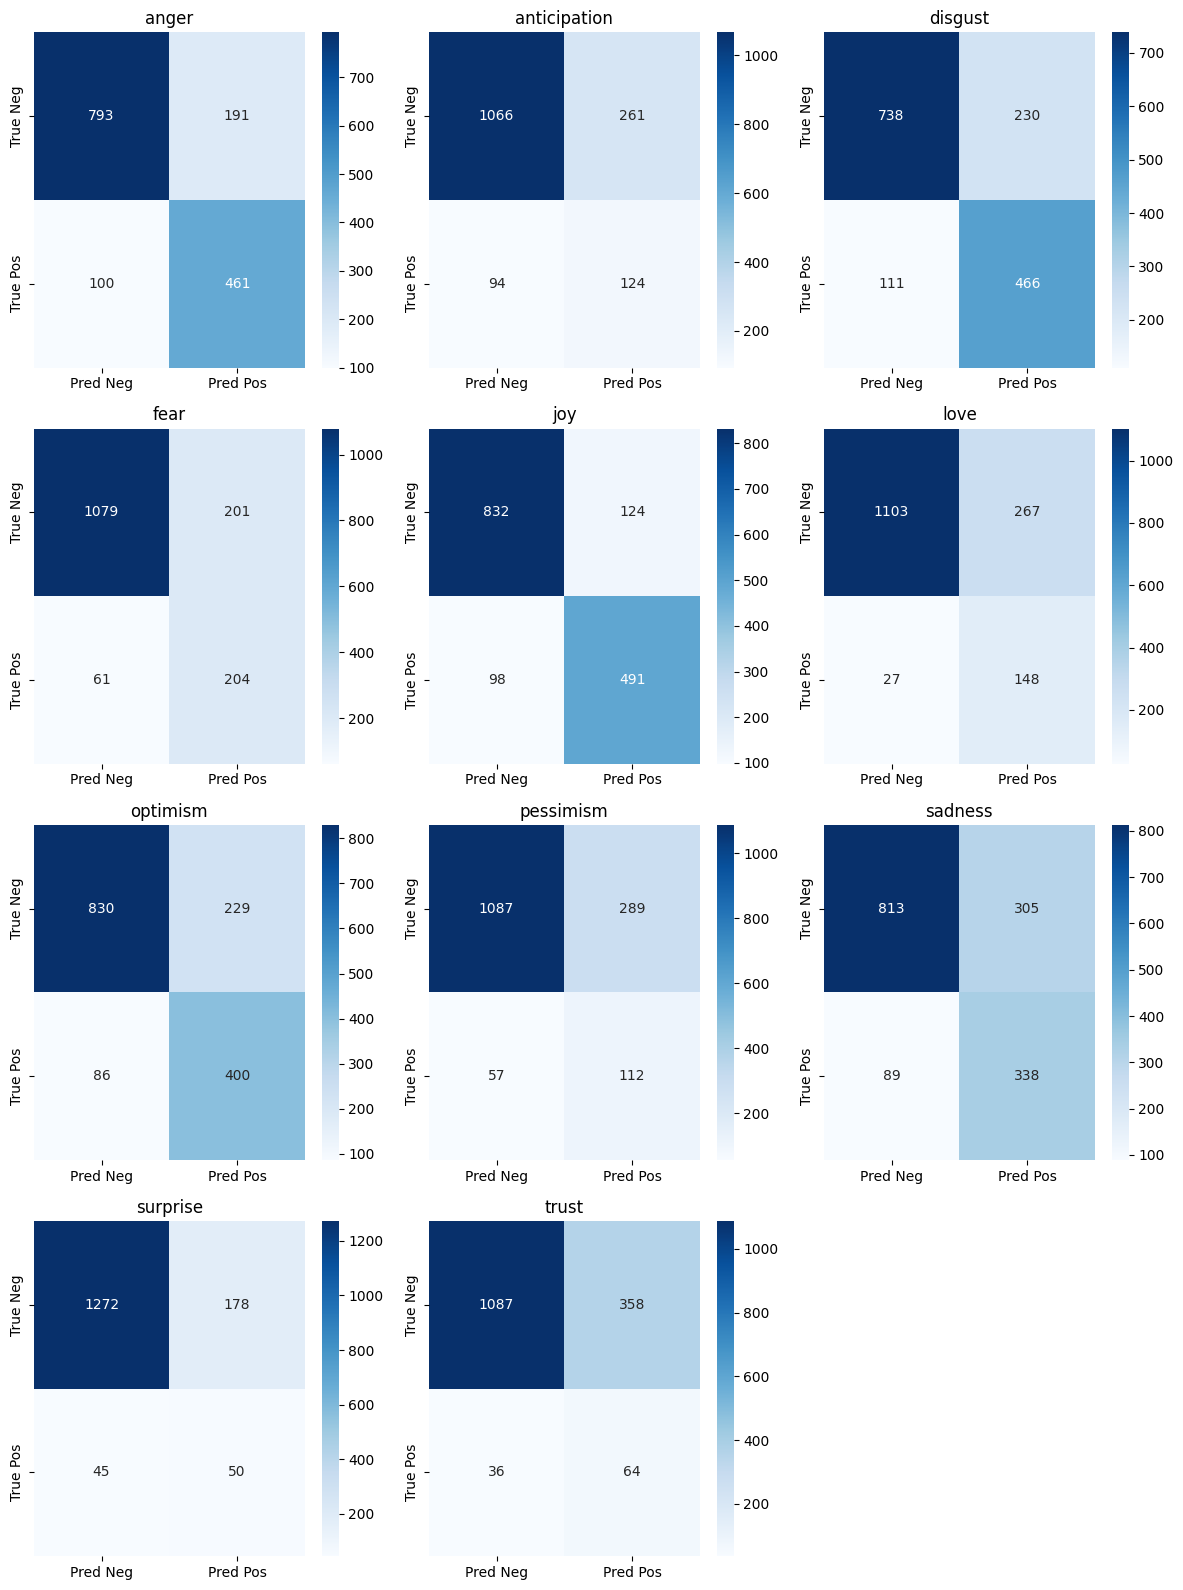

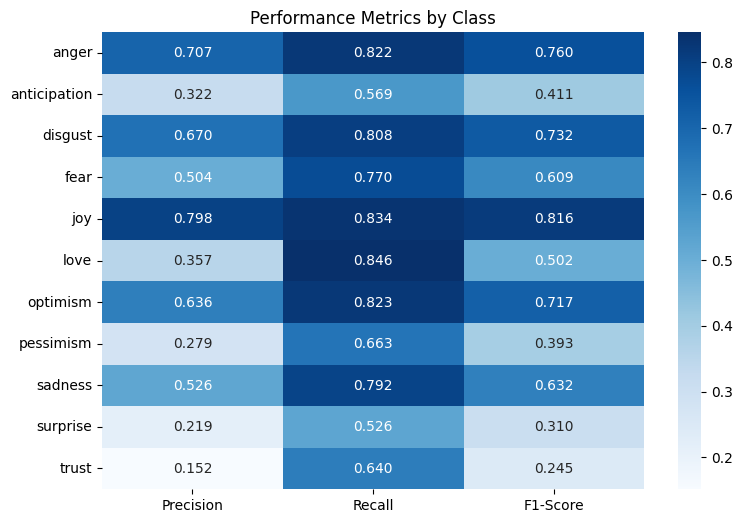

<Figure size 1200x533.333 with 0 Axes>

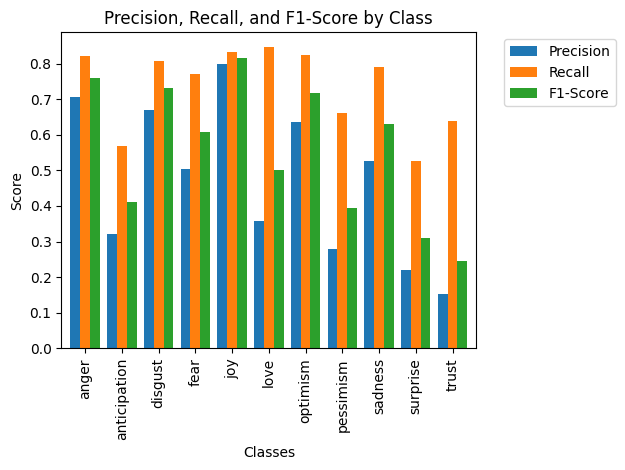

{'macro_avg': {'precision': np.float64(0.46992975737290227),
  'recall': np.float64(0.7355430738472197),
  'f1': np.float64(0.5569840600891549)},
 'per_class': {'Precision': {'anger': 0.7070552147239264,
   'anticipation': 0.3220779220779221,
   'disgust': 0.6695402298850575,
   'fear': 0.5037037037037037,
   'joy': 0.7983739837398374,
   'love': 0.3566265060240964,
   'optimism': 0.6359300476947536,
   'pessimism': 0.2793017456359102,
   'sadness': 0.5256609642301711,
   'surprise': 0.21929824561403508,
   'trust': 0.15165876777251186},
  'Recall': {'anger': 0.82174688057041,
   'anticipation': 0.5688073394495413,
   'disgust': 0.8076256499133448,
   'fear': 0.769811320754717,
   'joy': 0.833616298811545,
   'love': 0.8457142857142858,
   'optimism': 0.823045267489712,
   'pessimism': 0.6627218934911243,
   'sadness': 0.7915690866510539,
   'surprise': 0.5263157894736842,
   'trust': 0.64},
  'F1-Score': {'anger': 0.7600989282769992,
   'anticipation': 0.41127694859038144,
   'disgust

In [96]:
multilabel_evaluation(y_true=test_labels, y_pred=test_preds, class_names=class_names, figsize=(12, 8))

In [97]:
wandb.finish()

eval/f1_macro,▁▂▄▄▄▅▆▆▆▇▇▇▇▇▇▇██████████████
eval/loss,█▇▇▆▅▅▄▄▃▃▃▃▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,█▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▂
eval/samples_per_second,▁███████████▇▇▇▇▇██▇██████▇▇█▇
eval/steps_per_second,▁███████████▇▇▇▇▇██▇██████▇▇█▇
eval_f1_macro,▁
eval_loss,▁
test/f1_macro,▁
test/loss,▁
test/runtime,▁
+9,...


# <Font color = 'indianred'> **8. Model Inference**



In [98]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=0,
    return_all_scores=True,
    function_to_apply='sigmoid')

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


<font color = 'indianred'> **Test the pipeline on a single example**

In [99]:
sample = test_split['text'][0]
preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.021329456940293312},
  {'label': 'anticipation', 'score': 0.09366370737552643},
  {'label': 'disgust', 'score': 0.01095464825630188},
  {'label': 'fear', 'score': 0.01730727218091488},
  {'label': 'joy', 'score': 0.9899088144302368},
  {'label': 'love', 'score': 0.9949216246604919},
  {'label': 'optimism', 'score': 0.8764731287956238},
  {'label': 'pessimism', 'score': 0.010907281190156937},
  {'label': 'sadness', 'score': 0.04527418315410614},
  {'label': 'surprise', 'score': 0.21698474884033203},
  {'label': 'trust', 'score': 0.7945848107337952}]]

In [100]:
def get_positive_labels(pipeline_output, optimal_thresholds, label2id=None):

   positive_labels = []

   for pred_set in pipeline_output:
       # Get scores for all labels
       scores = [pred['score'] for pred in pred_set]
       labels = [pred['label'] for pred in pred_set]

       # Get positions where score > threshold for that label
       sample_positives = [
           label for label, score, threshold in zip(labels, scores, optimal_thresholds)
           if score >= threshold
       ]

       positive_labels.append(sample_positives)

   return positive_labels


In [101]:
results = get_positive_labels(preds, optimal_thresholds)
results

[['joy', 'love', 'optimism']]

<font color = 'indianred'> **Test the pipeline on a large dataset**

In [102]:
def predict_batch(examples):
    return {'predictions': custom_pipeline(examples['text'], truncation=True)}


results = test_split.map(
    predict_batch,
    batched=True,
    batch_size=16,

)

predictions = results['predictions']

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [103]:
predictions[0:3]


[[{'label': 'anger', 'score': 0.021329456940293312},
  {'label': 'anticipation', 'score': 0.09366370737552643},
  {'label': 'disgust', 'score': 0.01095464825630188},
  {'label': 'fear', 'score': 0.01730727218091488},
  {'label': 'joy', 'score': 0.9899088144302368},
  {'label': 'love', 'score': 0.9949216246604919},
  {'label': 'optimism', 'score': 0.8764731287956238},
  {'label': 'pessimism', 'score': 0.010907281190156937},
  {'label': 'sadness', 'score': 0.04527418315410614},
  {'label': 'surprise', 'score': 0.21698474884033203},
  {'label': 'trust', 'score': 0.7945848107337952}],
 [{'label': 'anger', 'score': 0.3493058383464813},
  {'label': 'anticipation', 'score': 0.1662037968635559},
  {'label': 'disgust', 'score': 0.1309356540441513},
  {'label': 'fear', 'score': 0.00848925206810236},
  {'label': 'joy', 'score': 0.9706209301948547},
  {'label': 'love', 'score': 0.8815807700157166},
  {'label': 'optimism', 'score': 0.6794379949569702},
  {'label': 'pessimism', 'score': 0.0058984342

In [104]:
results = get_positive_labels(predictions, optimal_thresholds)
results[0:3]

[['joy', 'love', 'optimism'], ['joy', 'love'], ['anticipation', 'joy']]

<font color = 'indianred'>TASK 2: How is ModernBERT different from BERT?

## Context length
- **BERT:** max ~**512** tokens.  
- **ModernBERT:** native **8,192** tokens (≈16× more). Great for long docs, RAG, and retrieval-heavy tasks.

## Positional & attention mechanics
- **BERT:** learned **absolute position embeddings**; **dense full attention**.
- **ModernBERT:** **RoPE (rotary)** for long context + **local–global alternating attention** for efficiency on long inputs; also uses **FlashAttention** and **unpadding** to reduce wasted compute.

## Blocks & activations
- **BERT:** **GELU**-based feed-forward layers.
- **ModernBERT:** updated MLPs (e.g., **GeGLU**) and other modern encoder tweaks for stability and throughput.

## Training scale
- **BERT (2018):** trained on **BookCorpus + English Wikipedia** (billions of tokens; small by today’s standards).
- **ModernBERT:** trained on **~2 trillion tokens**, including substantial **code**, which helps search/IDE and structured-text tasks.

## Speed/accuracy
- **ModernBERT** is designed as a **Pareto improvement** (typically faster *and* stronger) over classic BERT-family encoders, thanks to the architectural and systems upgrades above.
